# Capstone The Toll Of Traffic

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import json
import requests

# import k-means for clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Map rendering
import folium
from geopy.geocoders import Nominatim    # Converts given address to latitude and longitude

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import seaborn
import seaborn as sns

## Importing geospacial data for neighborhoods in Bangalore 

In [2]:
location_coordinates = pd.read_csv("./assets/Bangalore/blr_neighborhoods.csv", index_col=0)
print(f'Shape of dataframe: {location_coordinates.shape}')
location_coordinates.head()

Shape of dataframe: (352, 3)


,Neighborhood,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683116


In [3]:
# The DataFrame consists of 352 locations with their latitude and longitude details

In [4]:
# Using geopy to get coordinate values for Bangalore
geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode("Bangalore,India")
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bangalore are 12.9791198, 77.5912997.


## Create a map of Bangalore superimposed with Neighbourhoods

_Using Folim library to plot neighborhoods on the map._

In [5]:
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(location_coordinates['Latitude'], location_coordinates['Longitude'], location_coordinates['Neighborhood']):
    label = f'{neighborhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#25e6b9',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bangalore)
    
map_bangalore

![Map with outliers](./assets/Bangalore/images/Map_with_outliers.PNG)

In [6]:
# We see that the dataset contains a lot of outliers
# We consider locations in range
# Longitude in range 77.0 to 78.0
# Latitude in range 13.5 to 12.67

In [7]:
# Strip longitude outliers
location_coordinates = location_coordinates[(location_coordinates['Longitude'] >= 77.0) & (location_coordinates['Longitude'] <= 78.0)]

In [8]:
# Strip latitude outliers
location_coordinates = location_coordinates[(location_coordinates['Latitude'] >= 12.67) & (location_coordinates['Latitude'] <= 13.5)]

In [9]:
# Reset the index to dataframe
location_coordinates.reset_index(drop=True, inplace=True)
# Printing new DataFrame shape
print(f'The shape of new DataFrame is: {location_coordinates.shape}')
location_coordinates.head()

The shape of new DataFrame is: (233, 3)


,Neighborhood,Latitude,Longitude
0,Amruthahalli,13.066513,77.596624
1,Banaswadi,13.014162,77.651854
2,Bhattarahalli,13.025800,77.714279
3,Byatarayanapura,13.062074,77.596392
4,Devanagundi,12.973613,77.839402


_Plotting neighborhood data without outliers_

In [10]:
# Using geopy to get coordinate values for Bangalore
geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode("Bangalore,India")
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bangalore are 12.9791198, 77.5912997.


In [11]:
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=9.5)

folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        popup='Bangalore',
        color='Red',
        fill=True,
        fill_color='##fc0317',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangalore)

# add markers to map
for lat, lng, neighborhood in zip(location_coordinates['Latitude'], location_coordinates['Longitude'], location_coordinates['Neighborhood']):
    label = f'{neighborhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#25e6b9',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bangalore)
    
map_bangalore

![Map without outliers](./assets/Bangalore/images/Map_without_outliers.PNG)

In [12]:
# Now that we have the cleaned dataset, let us use foursquare API to get venues near each neighborhood

## Using Foursquare API to get data for nearby venues of each neighborhood

In [13]:
# Using your credentials for Foursquare API
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'

In [14]:
# Function to extract the category of a venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# Function to retrieve nearby venues for given latitude and longitude
# Radius is the range in which the venues should be from specified coordinates
# LIMIT is a cap on number of venues returned
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    '''Call FourSquare api to retrieve nearby venues'''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(requests.get(url).json())
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('An Error ouccured.\nYour quota may have been exceeded')
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# Setting limit to 100 and searching in 1km radius from location
radius = 1000
LIMIT = 100
# Calling the function and retrieving the result in a DataFrame
bangalore_venues = getNearbyVenues(names=location_coordinates['Neighborhood'],latitudes=location_coordinates['Latitude'],longitudes=location_coordinates['Longitude'],radius=radius, LIMIT=LIMIT)

Amruthahalli
Banaswadi
Bhattarahalli
Byatarayanapura
Devanagundi
Devasandra
Doddanekkundi
Domlur
An Error ouccured.
Your quota may have been exceeded
EPIP
An Error ouccured.
Your quota may have been exceeded
Hoodi
Horamavu
Indiranagar S.O (Bangalore)
Jakkur
Kadugodi
Kannamangala
Kodigehalli
Kundalahalli
Lingarajapuram
Medimallasandra
Panathur
Rajanakunte
Sadashivanagar
Samethanahalli
Singanayakanahalli
Vimanapura
Virgonagar
Yelahanka
Adugodi
Bommanahalli S.O (Bangalore)
Chickpet
Chikkalasandra
Deepanjalinagar
Doddakallasandra
Girinagar S.O (Bangalore)
Gottigere
Haragadde
Hennagara
Hulimangala
Huskur
Jayanagar H.O
Jigani
Kalkere
Kallubalu
Kathriguppe
Kengeri
Konanakunte
Koramangala
Kumbalagodu
Madivala
Mallathahalli
Mavalli
Nayandahalli
Ragihalli
Ramohalli
Sakalavara
Singasandra
Subramanyapura
Sulikere
Taralu
Thalaghattapura
Yelachenahalli
Achitnagar
Bagalgunte
Bangalore City
Basaveshwaranagar
Byatha
Herohalli
Hessarghatta
Jalahalli H.O
Kakolu
Kamakshipalya
Kodigehalli
Kodigehalli
Lagge

In [17]:
bangalore_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amruthahalli,13.066513,77.596624,The Druid Garden,13.063946,77.591492,Brewery
1,Amruthahalli,13.066513,77.596624,Big Straw,13.063414,77.591192,Bubble Tea Shop
2,Amruthahalli,13.066513,77.596624,Shivas Kabab Corner,13.062748,77.591789,Indian Restaurant
3,Amruthahalli,13.066513,77.596624,Swensen's,13.063476,77.590793,Ice Cream Shop
4,Amruthahalli,13.066513,77.596624,McDonald's,13.063687,77.589573,Fast Food Restaurant


In [18]:
# Saving the dataframe due to FourSquare API limit
bangalore_venues.to_csv('./assets/Bangalore/venues.csv')

In [65]:
# Import data from dataframe
venues_df  = pd.read_csv('./assets/Bangalore/venues.csv', index_col=0)
print(f'The shape of returned venues dataframe is: {venues_df.shape}')
venues_df.head()

The shape of returned venues dataframe is: (1215, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amruthahalli,13.066513,77.596624,The Druid Garden,13.063946,77.591492,Brewery
1,Amruthahalli,13.066513,77.596624,Big Straw,13.063414,77.591192,Bubble Tea Shop
2,Amruthahalli,13.066513,77.596624,Shivas Kabab Corner,13.062748,77.591789,Indian Restaurant
3,Amruthahalli,13.066513,77.596624,Swensen's,13.063476,77.590793,Ice Cream Shop
4,Amruthahalli,13.066513,77.596624,McDonald's,13.063687,77.589573,Fast Food Restaurant


In [42]:
# Let us see the total categories and their count
venue_count = venues_df[['Venue Category', 'Venue']].groupby('Venue Category').count().sort_values('Venue',ascending=False).rename({'Venue':'Count'}, axis='columns')

In [51]:
# We observe that most of the returned venues are restaurants and cafes
venue_count.reset_index(inplace=True, drop=True)

In [84]:
print(f'There are {len(venue_count.index)} unique categories of venues returned')

There are 182 unique categories of venues returned


In [85]:
venue_count.head()

,Venue Category,Count
0,Indian Restaurant,202
1,Café,77
2,Ice Cream Shop,53
3,Department Store,39
4,Fast Food Restaurant,37


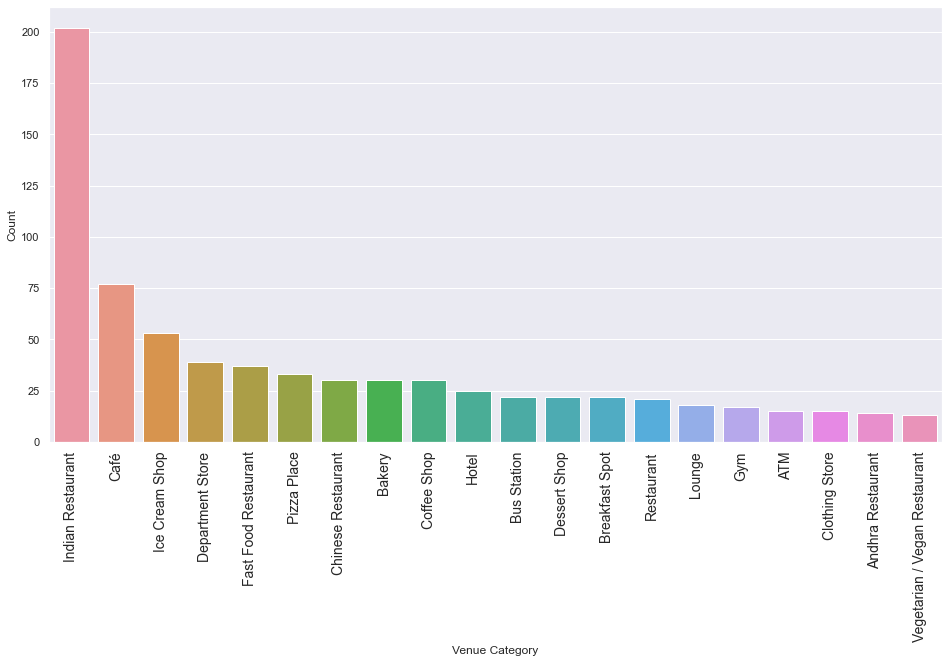

In [63]:
# Plotting a bargraph of top 20 returned venue categories
sns.set(style='darkgrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='Venue Category', y='Count',data=venue_count[0:20])
ax.set_xticklabels(venue_count['Venue Category'], rotation='vertical', fontsize=14)
plt.show()

In [74]:
# Now we group by Neighborhood to see the number of venues returned in each neighborhood

venue_neighborhood = venues_df.groupby(["Neighborhood"]).count()[['Venue']].rename({'Venue':'Count'}, axis='columns').sort_values('Count', ascending=False)

In [75]:
venue_neighborhood.head()

,Count
Neighborhood,
Indiranagar S.O (Bangalore),100
Jayanagar H.O,100
Koramangala,100
Thippasandra,76
Rameshwara,58


In [70]:
# We see that most venues are returned for posh areas like Indiranagar

In [76]:
venue_neighborhood.reset_index(inplace=True)

In [77]:
venue_neighborhood.head()

,Neighborhood,Count
0,Indiranagar S.O (Bangalore),100
1,Jayanagar H.O,100
2,Koramangala,100
3,Thippasandra,76
4,Rameshwara,58


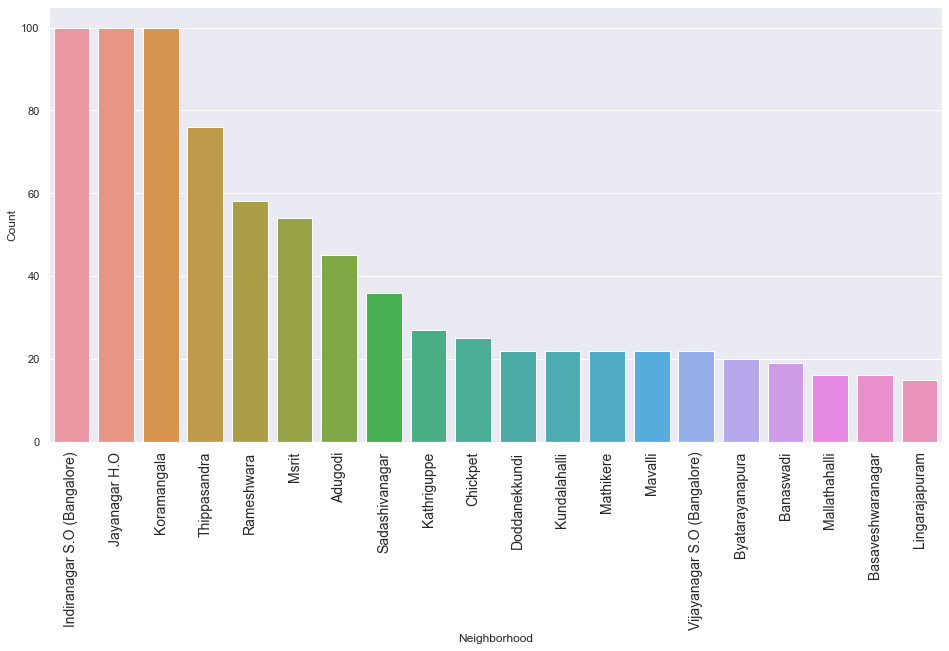

In [79]:
# Plotting a bargraph of top 20 neighborhoods with most venues
plt.figure(figsize=(16,8))
ax = sns.barplot(x='Neighborhood', y='Count',data=venue_neighborhood[0:20])
ax.set_xticklabels(venue_neighborhood['Neighborhood'], rotation='vertical', fontsize=14)
plt.show()

In [80]:
# We see uneven number of venues returned for different areas.
# This may be due to a problem with Foursquare API data.

## Creating features using venue categories of each neighborhood

In [87]:
venues_new = venues_df[['Neighborhood', 'Venue', 'Venue Category']]

In [99]:
# Using one hot encoding
bangalore_onehot = pd.get_dummies(venues_new[['Venue Category']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
bangalore_onehot['Neighborhoods'] = venues_new['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(bangalore_onehot.columns[-1:]) + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]


bangalore_grouped = bangalore_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(f'There are {bangalore_grouped.shape[0]-1} Neighborhoods and {bangalore_grouped.shape[1] - 1} venue categories.')
bangalore_grouped.head()

There are 101 Neighborhoods and 182 venue categories.


,Neighborhoods,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Travel & Transport,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Water Park,Wine Bar,Women's Store,Yoga Studio
0,Achitnagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adugodi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alahalli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amruthahalli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Anekal,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataframe to display top 10 venues of each postal code

In [98]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = bangalore_grouped['Neighborhoods']

for ind in np.arange(bangalore_grouped.shape[0]):
    row_categories = bangalore_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(102, 11)


,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Achitnagar,Bakery,Food & Drink Shop,Asian Restaurant,Yoga Studio,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant
1,Adugodi,Indian Restaurant,Dessert Shop,Café,Lounge,Multiplex,Bookstore,Brewery,Coffee Shop,Donut Shop,Salon / Barbershop
2,Alahalli,Food & Drink Shop,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm
3,Amruthahalli,Indian Restaurant,Bus Station,Pizza Place,Fast Food Restaurant,Bubble Tea Shop,Chinese Restaurant,Brewery,Hotel,Ice Cream Shop,Diner
4,Anekal,ATM,Business Service,Movie Theater,Department Store,Dessert Shop,Food,Flower Shop,Flea Market,Financial or Legal Service,Field
...,...,...,...,...,...,...,...,...,...,...,...
97,Vimanapura,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Hotel,Restaurant,Bus Stop,Farmers Market,Gym,Event Service
98,Virgonagar,Breakfast Spot,University,Lake,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Financial or Legal Service,Field
99,Yadavanahalli,Resort,Hotel Bar,Restaurant,Yoga Studio,Electronics Store,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
100,Yelachenahalli,Café,Pizza Place,Department Store,Indian Restaurant,Restaurant,Metro Station,Athletics & Sports,Motorcycle Shop,Flower Shop,Flea Market


## Clustering areas using KNN


First step is to determine how many clusters we should divide the neighbourhoods into. Let's use the visual Elbow method.

We'll loop through using 1 to 25 clusters and get the scores in a list.

In [106]:
bangalore_grouped_clustering = bangalore_grouped.drop(["Neighborhoods"], 1)
num_clusters = range(1, 25)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]

# Score saves score for num_clusters
score = [kmeans[i].fit(bangalore_grouped_clustering).score(bangalore_grouped_clustering) for i in range(len(kmeans))]

Next, we plot the score vs the number of clusters and look for the "elbow" where you get diminishing returns

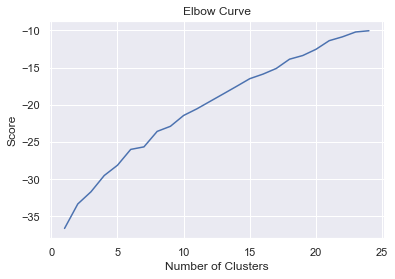

In [107]:
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

The elbow is not definite in the curve but the curve starts to become stable around 6.

We will use 6 as the number of clusters.

In [108]:
# setting number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[20:30]

array([1, 1, 3, 3, 3, 3, 3, 1, 0, 1])

# Adding cluster labels back to our original data set

In [115]:
res = venues_df.groupby(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']).count()
res['Cluster Labels'] = kmeans.labels_

In [118]:
res.drop(['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)

In [125]:
res.reset_index(inplace=True)
res.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels
0,Achitnagar,13.091176,77.483482,3
1,Adugodi,12.942847,77.610416,3
2,Alahalli,13.276586,77.522337,4
3,Amruthahalli,13.066513,77.596624,1
4,Anekal,12.708637,77.699397,0


## Now that we have the neighbirhoods divided into clusters we can plot them

In [128]:
# Visualising Clusters

# Using geopy to get coordinate values for Bangalore
geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode("Bangalore,India")
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Maraker for Bangalore
folium.CircleMarker(
        [latitude, longitude],
        radius=9,
        popup='Bangalore',
        color='Yellow',
        fill=True,
        fill_color='Black',
        fill_opacity=1).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, nei_name, cluster in zip(res['Neighborhood Latitude'], res['Neighborhood Longitude'], res['Neighborhood'], res['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(nei_name, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

![Map of clustered neighborhoods of Bangalore](./assets/Bangalore/images/clusters.PNG "Map of clustered neighborhoods of Bangalore")

## Examining each cluster

__Cluster 0__

In [130]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 0]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Anekal,ATM,Business Service,Movie Theater,Department Store,Dessert Shop,Food,Flower Shop,Flea Market,Financial or Legal Service,Field
19,Chikkanahalli,ATM,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm
28,Harohalli,ATM,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm
45,Kamakshipalya,ATM,Bus Station,Restaurant,Campground,Fast Food Restaurant,Breakfast Spot,Hobby Shop,Flea Market,Hotel,Field
55,Laggere,ATM,Pizza Place,Pharmacy,Event Service,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
90,Taralu,ATM,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm


__Cluster 1__

In [131]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 1]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Amruthahalli,Indian Restaurant,Bus Station,Pizza Place,Fast Food Restaurant,Bubble Tea Shop,Chinese Restaurant,Brewery,Hotel,Ice Cream Shop,Diner
5,Attibele,ATM,South Indian Restaurant,Photography Studio,Castle,Indian Restaurant,Animal Shelter,Event Space,Food,Flower Shop,Flea Market
8,Banaswadi,Indian Restaurant,Café,Department Store,Clothing Store,Kerala Restaurant,Andhra Restaurant,Pizza Place,Bistro,Tea Room,Convenience Store
10,Basaveshwaranagar,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Intersection,Department Store,Juice Bar,Bus Station,Pizza Place,Gym,Café
12,Bidadi,Indian Restaurant,Train Station,Breakfast Spot,Event Space,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant
15,Byatarayanapura,Indian Restaurant,Ice Cream Shop,Hotel,Brewery,Pizza Place,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Café,Bus Station
16,Chickpet,Indian Restaurant,Miscellaneous Shop,Market,Theater,Flower Shop,Restaurant,Flea Market,Bookstore,Seafood Restaurant,Electronics Store
20,Chunchanakuppe,Indian Restaurant,Park,Deli / Bodega,Department Store,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
21,Deepanjalinagar,Indian Restaurant,Department Store,Metro Station,Bus Station,Travel & Transport,Train Station,Nightclub,Yoga Studio,Farm,Flea Market
27,Gottigere,Indian Restaurant,Department Store,Food Truck,Italian Restaurant,Ice Cream Shop,Event Service,Flower Shop,Flea Market,Financial or Legal Service,Field


__Cluster 2__

In [132]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 2]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Kalkere,Resort,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm
74,Neriga,Resort,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm


__Cluster 3__

In [133]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 3]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Achitnagar,Bakery,Food & Drink Shop,Asian Restaurant,Yoga Studio,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant
1,Adugodi,Indian Restaurant,Dessert Shop,Café,Lounge,Multiplex,Bookstore,Brewery,Coffee Shop,Donut Shop,Salon / Barbershop
6,Bagalgunte,Pizza Place,Bakery,Restaurant,Yoga Studio,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
7,Bagalur S.O (Bangalore),Food Truck,Memorial Site,Event Space,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
9,Bangalore City,Department Store,Restaurant,Shopping Plaza,Yoga Studio,Event Service,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...
97,Vimanapura,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Hotel,Restaurant,Bus Stop,Farmers Market,Gym,Event Service
98,Virgonagar,Breakfast Spot,University,Lake,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Financial or Legal Service,Field
99,Yadavanahalli,Resort,Hotel Bar,Restaurant,Yoga Studio,Electronics Store,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
100,Yelachenahalli,Café,Pizza Place,Department Store,Indian Restaurant,Restaurant,Metro Station,Athletics & Sports,Motorcycle Shop,Flower Shop,Flea Market


__Cluster 4__

In [134]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 4]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alahalli,Food & Drink Shop,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Farm


__Cluster 5__

In [135]:
neighborhoods_venues_sorted[res['Cluster Labels'] == 5]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Jalige,Farm,Yoga Studio,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
81,Sakalavara,Farm,Yoga Studio,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


* Cluster 0 is mainly composed of financial areas and markets.

* Cluster 1 is mainly composed of resteraunts and shopping districts along with areas for public transport.

* Custer 2 is composed of 2 locations both on the outskirts of the city and have a remarkebly similar layout in terms of most common locations. These are most likely locations on which the API couldn't get enough data.

* Cluster 3 is composed of areas with food courts and restaurants with places for leisure like movie theatres.

* Cluster 4 is just a town on city outskirts with marksets, restaurants and farms.

* Cluster 5 like Cluster 2 is composed of 2 neighborhoods for which the API would't have provided enough data.
The two neighborhoods here too are almost identical in their common venues.

# Conclusion

We can conculde from the above results that cluster 1 and 3 were the largest clusteres formed.

Cluster 0 appears to be a financial district and thus will recieve highest traffic and footfall on weekdays composed of people going for jobs.

Cluster 1 is composed of shopping districts and public transport stops. These neighborhoods tend to have traffic in rush hours as due to commuters going to work or returning from it.

Cluster 2, 4 and 5 are mostly composed of towns on the outskirts of the city which do not have a problem of packed roads.

Cluster 3 is the largest cluster and is composed mostly of food courts and places of Entertainment like movie theatres.<br>
These places are most likely to recieve a higher amount of traffic and more footfall on weekends composed of families shopping and people out for leisure.